In [3]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import joblib
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

In [1]:
# ───────────────────────────────────────────────────────────────────────────────
# 0. Configuration & File Paths
# ───────────────────────────────────────────────────────────────────────────────
DL_SHP       = "Te_ppm_DL_S_SOWETO.shp"
ORIG_SHP     = "Te_ppm_Orig_S_SOWETO.shp"
DL_PARQ      = "Te_ppm_DL_S_SOWETO.parquet"
ORIG_PARQ    = "Te_ppm_Orig_S_SOWETO.parquet"
TREE_DL_JOB  = "dl_tree.joblib"
TREE_ORIG_JOB= "orig_tree.joblib"
GRID_ZARR    = "perc_diff_grid.zarr"

# Target projected CRS for metre-based distances (e.g. UTM 35S)
TARGET_CRS = "EPSG:32735"

# Grid resolution in metres
GRID_SPACING = 100

In [4]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. Parquet Conversion (one-time)
# ───────────────────────────────────────────────────────────────────────────────
def ensure_parquet(shp_fp, parq_fp):
    if not os.path.exists(parq_fp):
        print(f"Converting {os.path.basename(shp_fp)} → Parquet…")
        gdf = gpd.read_file(shp_fp)
        gdf.to_parquet(parq_fp, index=False)

for shp, parq in [(DL_SHP, DL_PARQ), (ORIG_SHP, ORIG_PARQ)]:
    ensure_parquet(shp, parq)

In [5]:
# ───────────────────────────────────────────────────────────────────────────────
# 2. Load & Filter
# ───────────────────────────────────────────────────────────────────────────────
def load_gdf(parq_fp):
    gdf = gpd.read_parquet(parq_fp)         # fast columnar read
    gdf = gdf[gdf['Te_ppm'] > 0]             # drop non-positive
    return gdf.to_crs(TARGET_CRS)           # project to metres

dl_gdf   = load_gdf(DL_PARQ)
orig_gdf = load_gdf(ORIG_PARQ)

── Extended Tellurium Statistics ──
            count   mean  median  std_dev  variance  min    25%    75%    IQR  \
DL        1381433  0.753   0.069    6.320    39.941  0.0  0.048  0.136  0.088   
Original    78727  7.190   0.090   51.645  2667.204  0.0  0.040  0.200  0.160   

               max  skewness  kurtosis     cv  
DL        1079.446    28.432  2006.655  8.390  
Original  5000.000    33.453  2446.076  7.183  


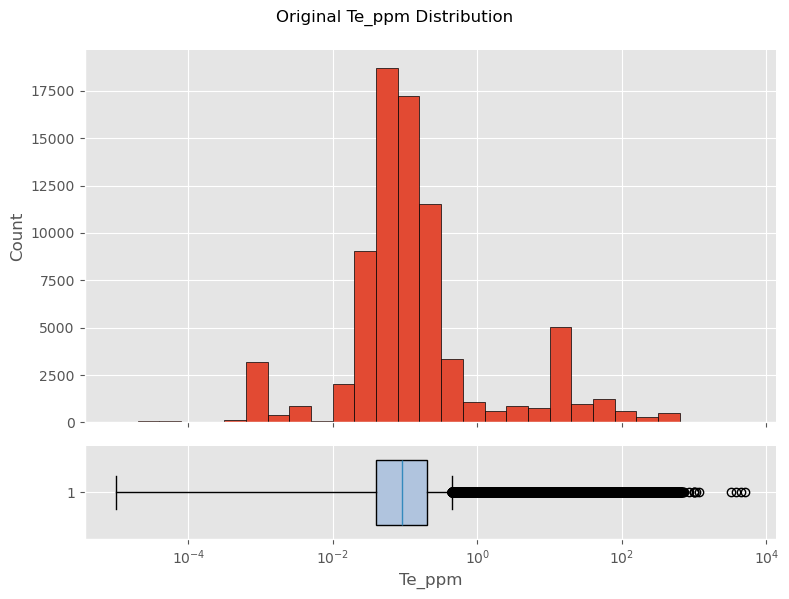

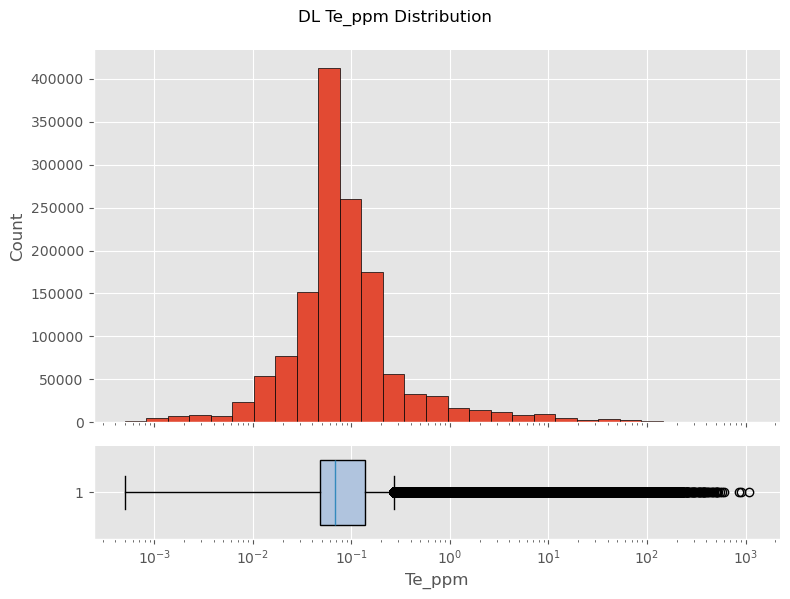

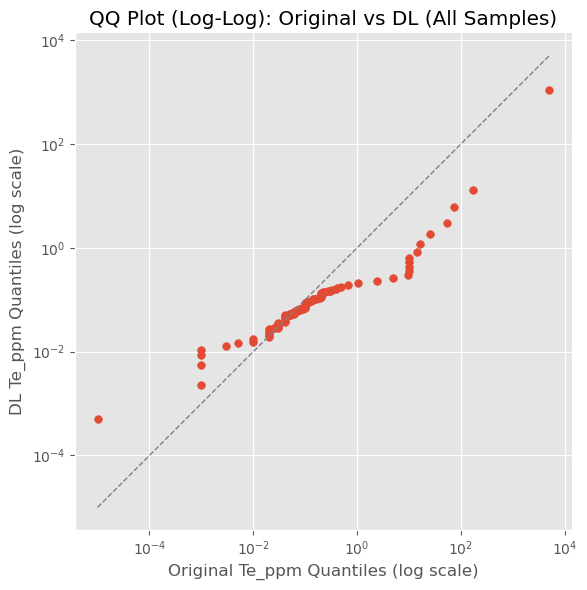

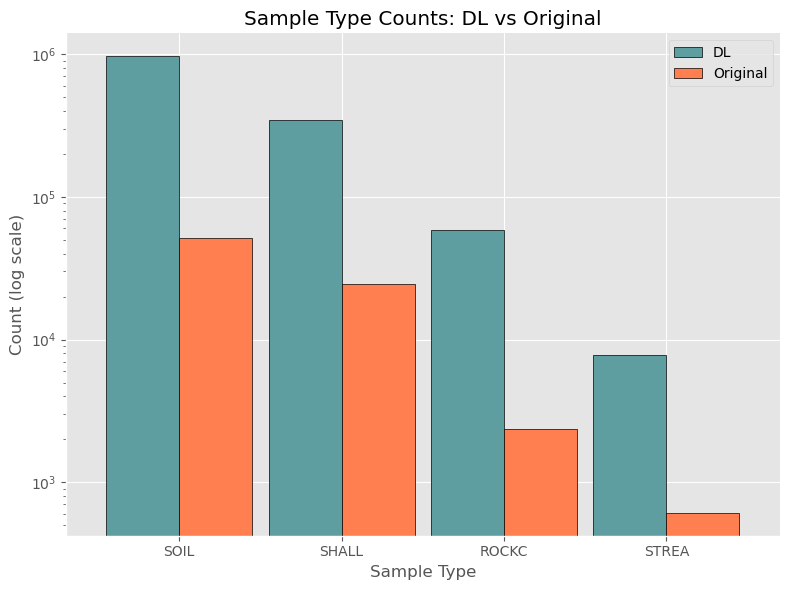

In [6]:
# ───────────────────────────────────────────────────────────────────────────────
# 3. Extended Statistics & EDA
# ───────────────────────────────────────────────────────────────────────────────
def compute_stats(te_series):
    return {
        'count':    te_series.count(),
        'mean':     te_series.mean(),
        'median':   te_series.median(),
        'std_dev':  te_series.std(),
        'variance': te_series.var(),
        'min':      te_series.min(),
        '25%':      te_series.quantile(0.25),
        '75%':      te_series.quantile(0.75),
        'IQR':      te_series.quantile(0.75) - te_series.quantile(0.25),
        'max':      te_series.max(),
        'skewness': te_series.skew(),
        'kurtosis': te_series.kurtosis(),
        'cv':   te_series.std() / te_series.mean()
    }

# Build stats table
dl_stats   = compute_stats(dl_gdf['Te_ppm'])
orig_stats = compute_stats(orig_gdf['Te_ppm'])
stats_df   = pd.DataFrame([dl_stats, orig_stats], index=['DL', 'Original']).round(3)
print("── Extended Tellurium Statistics ──")
print(stats_df)

# Plot style
plt.style.use('ggplot')

# 3a. Log-scale histogram + boxplot
def plot_dist(gdf, label):
    te = gdf['Te_ppm']
    bins = np.logspace(np.log10(te.min()), np.log10(te.max()), 30)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                                   gridspec_kw={'height_ratios':[4,1]},
                                   figsize=(8,6))
    fig.suptitle(f"{label} Te_ppm Distribution", y=0.99)
    ax1.hist(te, bins=bins, edgecolor='black')
    ax1.set_xscale('log'); ax1.set_ylabel('Count')
    ax2.boxplot(te, vert=False, widths=0.7, patch_artist=True,
                boxprops=dict(facecolor='lightsteelblue'))
    ax2.set_xscale('log'); ax2.set_xlabel('Te_ppm')
    for ax in (ax1, ax2):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_dist(orig_gdf, "Original")
plot_dist(dl_gdf,   "DL")

# 3b. QQ-plot of Overall DL vs Original on Log-Log Scale
orig_vals = orig_gdf['Te_ppm'].values
dl_vals   = dl_gdf['Te_ppm'].values
n_q       = min(len(orig_vals), len(dl_vals), 100)
quantiles = np.linspace(0, 100, n_q)
q_orig    = np.percentile(orig_vals, quantiles)
q_dl      = np.percentile(dl_vals,   quantiles)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(q_orig, q_dl, s=30)
m, M = min(q_orig.min(), q_dl.min()), max(q_orig.max(), q_dl.max())
ax.plot([m, M], [m, M], '--', color='grey', linewidth=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('QQ Plot (Log-Log): Original vs DL (All Samples)')
ax.set_xlabel('Original Te_ppm Quantiles (log scale)')
ax.set_ylabel('DL Te_ppm Quantiles (log scale)')
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# 3c. Sample-type counts
# Compute counts
counts = pd.DataFrame({
    'DL':       dl_gdf['SAMPLETYPE'].value_counts(),
    'Original': orig_gdf['SAMPLETYPE'].value_counts()
}).fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(
    kind='bar',
    ax=ax,
    color=['cadetblue', 'coral'],
    edgecolor='black',
    width=0.9
)

ax.set_yscale('log')
ax.set_title('Sample Type Counts: DL vs Original')
ax.set_xlabel('Sample Type')
ax.set_ylabel('Count (log scale)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=0)
plt.legend(title='')
plt.tight_layout()
plt.show()


In [7]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. KD-Tree Caching
# ───────────────────────────────────────────────────────────────────────────────
def get_tree(gdf, cache_fp):
    if os.path.exists(cache_fp):
        return joblib.load(cache_fp)
    pts = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
    tree = cKDTree(pts)
    joblib.dump(tree, cache_fp)
    return tree

dl_tree   = get_tree(dl_gdf,   TREE_DL_JOB)
orig_tree = get_tree(orig_gdf, TREE_ORIG_JOB)

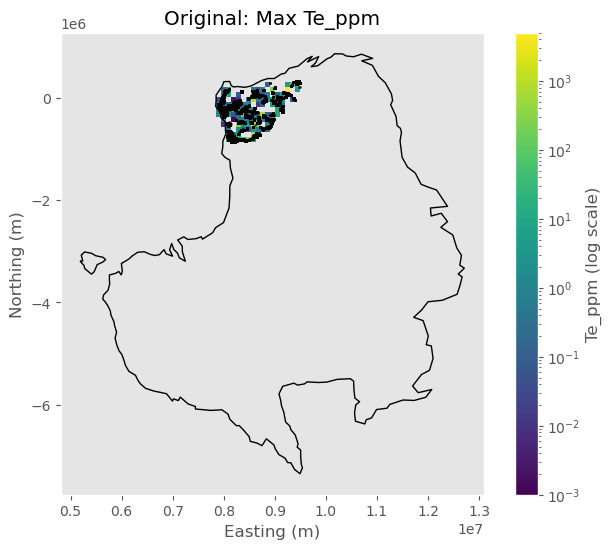

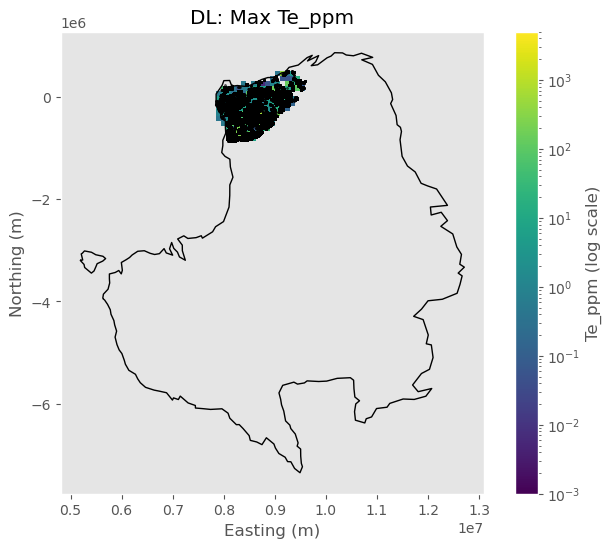

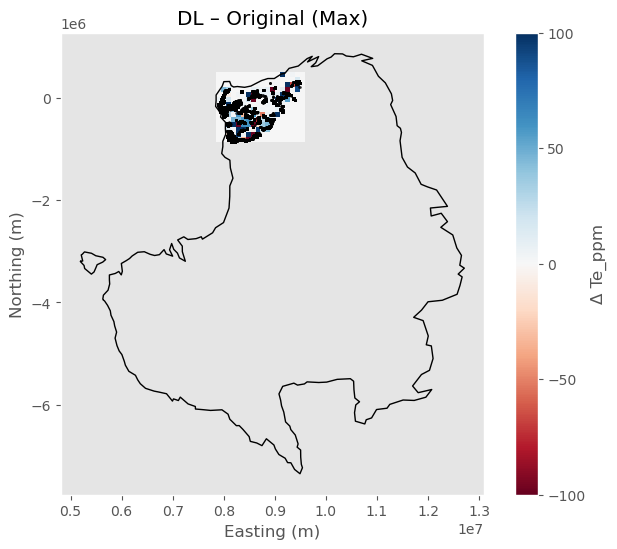

In [10]:
# ───────────────────────────────────────────────────────────────────────────────
# 5. Build & Display Raster Maps with comparison methods from comparisons.py
# ───────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
import numpy as np

# import your comparison library
from comparisons import COMPARISON_METHODS

# 5.1 Configuration
spacing = 100000   # 100 km grid
minx1, miny1, maxx1, maxy1 = dl_gdf.total_bounds
minx2, miny2, maxx2, maxy2 = orig_gdf.total_bounds
minx, miny = min(minx1, minx2), min(miny1, miny2)
maxx, maxy = max(maxx1, maxx2), max(maxy1, maxy2)
nx = int(np.ceil((maxx - minx) / spacing))
ny = int(np.ceil((maxy - miny) / spacing))
extent = [minx, maxx, miny, maxy]

# 5.2 Assign each sample a grid cell index
def assign_grid_indices(gdf, minx, miny, spacing):
    gdf = gdf.copy()
    gdf["grid_ix"] = ((gdf.geometry.x - minx) // spacing).astype(int)
    gdf["grid_iy"] = ((gdf.geometry.y - miny) // spacing).astype(int)
    return gdf

dl_idx   = assign_grid_indices(dl_gdf, minx, miny, spacing)
orig_idx = assign_grid_indices(orig_gdf, minx, miny, spacing)

# 5.3 Select comparison method
method_name = "max"   # change to "mean", "median", "chi2" as needed
compare_fn = COMPARISON_METHODS[method_name]

arr_orig, arr_dl, arr_cmp = compare_fn(dl_idx, orig_idx, nx, ny)

# 5.4 Colour scales
all_vals = np.concatenate([
    arr_orig[arr_orig>0].ravel(),
    arr_dl[  arr_dl  >0].ravel()
])
log_norm  = LogNorm(vmin=all_vals.min(), vmax=all_vals.max())
diff_norm = plt.Normalize(vmin=-100, vmax=100)

# 5.5 Load Australia outline
countries = gpd.read_file("ne_110m_admin_0_countries.shp")
australia = countries[countries['ADMIN']=="Australia"].to_crs(orig_gdf.crs)

# 5a. Original
plt.figure(figsize=(8,6))
im = plt.imshow(arr_orig, origin='lower', extent=extent, cmap='viridis', norm=log_norm)
plt.scatter(orig_gdf.geometry.x, orig_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
plt.title(f"Original: {method_name.capitalize()} Te_ppm")
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
plt.colorbar(im, label='Te_ppm (log scale)')
plt.grid(False)
plt.show()

# 5b. DL
plt.figure(figsize=(8,6))
im = plt.imshow(arr_dl, origin='lower', extent=extent, cmap='viridis', norm=log_norm)
plt.scatter(dl_gdf.geometry.x, dl_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
plt.title(f"DL: {method_name.capitalize()} Te_ppm")
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
plt.colorbar(im, label='Te_ppm (log scale)')
plt.grid(False)
plt.show()

# 5c. Comparison
plt.figure(figsize=(8,6))
im = plt.imshow(arr_cmp, origin='lower', extent=extent, cmap='RdBu', norm=diff_norm)
plt.scatter(orig_gdf.geometry.x, orig_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
plt.title(f"DL – Original ({method_name.capitalize()})")
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
plt.colorbar(im, label='Δ Te_ppm', ticks=[-100, -50, 0, 50, 100])
plt.grid(False)
plt.show()


In [12]:
# ───────────────────────────────────────────────────────────────────────────────
# 5d. Export results to CSV
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd

def export_arrays_to_csv(arr_orig, arr_dl, arr_cmp, out_prefix="comparison"):
    """
    Save arr_orig, arr_dl, arr_cmp to CSVs with columns [grid_ix, grid_iy, value].
    """
    ny, nx = arr_orig.shape
    grid_ix, grid_iy = np.meshgrid(np.arange(nx), np.arange(ny))
    df = pd.DataFrame({
        "grid_ix": grid_ix.ravel(),
        "grid_iy": grid_iy.ravel(),
        "orig": arr_orig.ravel(),
        "dl": arr_dl.ravel(),
        "cmp": arr_cmp.ravel()
    })

    # One CSV with all three, and individual CSVs if desired
    df.to_csv(f"{out_prefix}_all.csv", index=False)
    df[["grid_ix", "grid_iy", "orig"]].to_csv(f"{out_prefix}_orig.csv", index=False)
    df[["grid_ix", "grid_iy", "dl"]].to_csv(f"{out_prefix}_dl.csv", index=False)
    df[["grid_ix", "grid_iy", "cmp"]].to_csv(f"{out_prefix}_cmp.csv", index=False)

    print(f"Exported: {out_prefix}_all.csv, {out_prefix}_orig.csv, {out_prefix}_dl.csv, {out_prefix}_cmp.csv")

# Example usage
export_arrays_to_csv(arr_orig, arr_dl, arr_cmp, out_prefix=f"comparison_{method_name}")


Exported: comparison_max_all.csv, comparison_max_orig.csv, comparison_max_dl.csv, comparison_max_cmp.csv


In [ ]:
import pandas as pd
import numpy as np

def load_arrays_from_csv(all_csv_path, nx, ny):
    """
    Reload arr_orig, arr_dl, arr_cmp from a previously exported CSV.

    Parameters
    ----------
    all_csv_path : str
        Path to the *_all.csv file produced by export_arrays_to_csv
    nx, ny : int
        Grid dimensions used in the export

    Returns
    -------
    arr_orig, arr_dl, arr_cmp : np.ndarray
    """
    df = pd.read_csv(all_csv_path)

    arr_orig = np.zeros((ny, nx))
    arr_dl   = np.zeros((ny, nx))
    arr_cmp  = np.zeros((ny, nx))

    for _, row in df.iterrows():
        ix, iy = int(row["grid_ix"]), int(row["grid_iy"])
        arr_orig[iy, ix] = row["orig"]
        arr_dl[iy, ix]   = row["dl"]
        arr_cmp[iy, ix]  = row["cmp"]

    return arr_orig, arr_dl, arr_cmp

# Example usage
arr_orig2, arr_dl2, arr_cmp2 = load_arrays_from_csv(
    "comparison_max_all.csv", nx, ny
)